Esta notebook va a llevar a adelante el Desafío N° 1 del curso de DataScience

In [1]:
# En primer lugar importamos las librerias con las que vamos a trabajar a lo largo del proyecto

import pandas as pd
import numpy as np
import seaborn as sns
import re

In [2]:
# Es necesario importar el dataset con el cual vamos a trabajar

file_path = "properati.csv"
data = pd.read_csv(file_path, sep = ",")
print(data.shape)
data.head(2)

(121220, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [3]:
data.dtypes.value_counts()

float64    13
object     12
int64       1
dtype: int64

Se observa que el dataset cuenta con 121000 observaciones y 26 variables, de las cuales 13 son numeros reales, 12 son strings y 1 es un entero (esta igual debemos removerla ya que se trata de un indice innecesario)

In [4]:
# Procedemos a remover la primer columna del dataset
data = data.iloc[:,1:]
data.head(2)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [5]:
# Algo interesante para mirar sería el tipo de dato que tiene cada variable

print(data.dtypes)
print("\n")

# Y también ver como se distribuyen los datos que son numericos
data.describe()

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object




,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,1.025030e+05,69670.000000,69670.000000,1.008100e+05,1.008100e+05,1.008100e+05,81892.000000,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04
mean,3.574442e+06,-34.626210,-59.266290,4.685259e+05,4.229397e+06,2.397006e+05,233.795328,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03
std,3.541306e+05,1.980936,2.299922,2.260101e+06,6.904714e+06,3.913239e+05,1782.222147,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05
min,3.427208e+06,-54.823985,-75.678931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00
25%,3.430234e+06,-34.669065,-58.727040,1.100000e+05,1.583309e+06,8.973388e+04,50.000000,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03
50%,3.433910e+06,-34.597985,-58.480128,1.850000e+05,2.558452e+06,1.450000e+05,84.000000,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03
75%,3.836668e+06,-34.441299,-58.395908,4.200000e+05,4.675792e+06,2.650000e+05,200.000000,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03
max,6.948895e+06,4.545843,-53.733330,6.500000e+08,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,4.000000e+06,3150.000000,32.000000,1.000150e+07


Se ve que hay algunas columnas que parecen no aportar mucha información al dataset, mas bien redundan basadas en otras columnas
En este sentido esto va en contra de la idea de "tidy data".
Sería una buena idea remover estas columnas

Por otro lado hay columnas muy poco relevantes como por ejemplo el URL de la publicación o el URL de las fotos presentes en el dataset. A simple vista se ve que esto no puede ser manejado por ningún modelo predictivo.
También seria relevanete remover estas columnas

In [6]:
data.drop(['place_with_parent_names', 'lat-lon'], axis = 1, inplace= True)
data.drop(['properati_url', 'image_thumbnail'], axis = 1, inplace= True)

Un análisis que es importante realizar es la presencia de datos faltantes que tiene el dataset.
A simple vista se ve que muchas de las variables numércias tienen varios valores faltantes, es necesario identificar que % de la data representa y si sería posible tomar una decisión de imputación.

Viendo los resultados mostrados en el gráfico, se puede observar que hay algunas variables con un importante % de valore faltantes (superiores al 50% de los datos - "floor", "expensas", "rooms"). En principio generar algún método de imputación parece ser muy complejo. Contamos tanto con la descripción de la publicación y con el título de la misma, por lo que se podría implementar un método regex para extraer estos datos

Con el resto de las variables numéricas podría intentar realziarse una imputación:
1. lon, lat: en estas variables no tiene tanto sentido ya que dependen mucho de la ubicación del inmueble y solo contambos con el barrio/ciudad. En caso de querer imputarlas podrían manejarse dos opciones
        1.a. poner la lon, lat que sale del barrio en Google Maps
        1.b. buscar en las descripciones los nombres de las calles o la dirección y con API de GoogleMaps extraer lon, lat
2. price_USD_per_m2: esto no es más que un cálculo en base a otras variables que también tienen datos faltantes, de ser posible estimar las anteriores de podría completar en su totalidad
3. El resto de las variables con algunos de los mecanismos de imputación podrían resolverse

<AxesSubplot:>

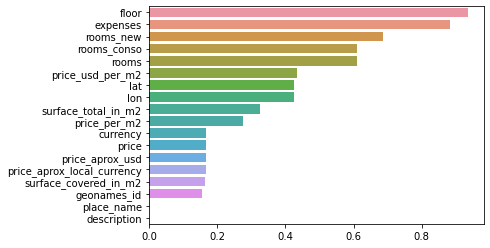

In [28]:
missing_data = data.isnull().sum(axis = 0) / data.shape[0]
missing_data.sort_values(inplace = True, ascending = False)
miss = missing_data[missing_data>0]

sns.barplot(y = miss.index, x = miss)

## Análisis del contenido de descripción y título

In [8]:
expresion = re.compile("\s*(?P<ambientes>\d{1,2})\s*amb", flags = re.IGNORECASE)

a = data.description.apply(lambda x: None if x is np.NaN else re.search(expresion, x))

b = a.apply(lambda x: x if x is None else x.group("ambientes"))

b.isnull().sum()

83166

In [9]:
expresion2 = re.compile("\s*(?P<ambientes>\d{1,2})\s*amb", flags = re.IGNORECASE)

a2 = data.title.apply(lambda x: None if x is np.NaN else re.search(expresion, x))

b2 = a2.apply(lambda x: x if x is None else x.group("ambientes"))

b2.isnull().sum()

99403

In [10]:
ambiente = pd.merge(b,b2, left_index = True, right_index = True)
ambiente = ambiente.assign(rooms = lambda x: x['title'] if x['description'] is None else x['description'])

print(ambiente.rooms.isnull().sum())

83166


In [32]:
# data = data.join(ambiente.rooms, rsuffix="_new")

data = data.assign(rooms_conso = lambda x: x['rooms'] if x['rooms_new'] is None else x['rooms_new'])
data[data.rooms.notnull()]

,operation,property_type,place_name,country_name,state_name,geonames_id,lat,lon,price,currency,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title,rooms_new,rooms_conso
13,sell,apartment,Palermo Soho,Argentina,Capital Federal,3430234.0,NaN,NaN,111700.0,USD,...,30.0,2234.000000,3723.333333,NaN,1.0,NaN,Torre I Mondrian. 3 ambientes con terraza y d...,Vitraux Palermo,3,3
14,sell,apartment,Palermo Soho,Argentina,Capital Federal,3430234.0,NaN,NaN,147900.0,USD,...,31.0,3521.428571,4770.967742,NaN,1.0,NaN,Torre II Dalí. Ambiente unico divisible.Vitrau...,Vitraux Palermo,None,None
16,sell,PH,Mataderos,Argentina,Capital Federal,3430787.0,-34.652356,-58.501624,239000.0,USD,...,98.0,1707.142857,2438.775510,NaN,4.0,NaN,Ventas Mataderos al frente Duplex 4 amb.- Plan...,VENTA-MATADEROS-DUPLEX 4 AMB.,4,4
17,sell,apartment,Barrio El Golf,Argentina,Bs.As. G.B.A. Zona Norte,NaN,-34.408717,-58.634389,315000.0,USD,...,78.0,1789.772727,4038.461538,NaN,3.0,NaN,Excelente 3 ambientes en un 6 piso y con terra...,3 ambientes en venta en Acqua Golf 1 en Nordel...,3,3
19,sell,apartment,Palermo,Argentina,Capital Federal,3430234.0,-34.580504,-58.405874,350000.0,USD,...,96.0,3365.384615,3645.833333,NaN,3.0,NaN,Excelente semipiso al contra frente en Bulnes ...,"Bulnes y Libertador: espectacular pulmón, con ...",None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120203,sell,apartment,Mar del Plata,Argentina,Buenos Aires Costa Atlántica,3430863.0,-38.002849,-57.544908,74000.0,USD,...,39.0,1897.435897,1897.435897,NaN,2.0,NaN,DEPARTAMENTO DE 2 AMBIENTES AL CONTRA-FRENTE M...,2 AMB AL CONTRA-FRENTE EN VENTA EDIFICIO CAMAR...,2,2
120204,sell,apartment,Mar del Plata,Argentina,Buenos Aires Costa Atlántica,3430863.0,-37.996638,-57.550819,45000.0,USD,...,27.0,1666.666667,1666.666667,NaN,1.0,NaN,FEIGELMULLER ESTUDIO INMOBILIARIO 9 A 13 Y 15 ...,DEPARTAMENTO 1 AMBIENTE CENTRO VENTA,1,1
120205,sell,apartment,Pinamar,Argentina,Buenos Aires Costa Atlántica,3429971.0,-37.099113,-56.840540,349000.0,USD,...,129.0,2342.281879,2705.426357,NaN,5.0,NaN,Hermoso semipiso frente al mar.Espectaculares ...,Impresionante semipiso frente al mar,None,None
120206,sell,house,Balcarce,Argentina,Buenos Aires Interior,3436176.0,-37.837561,-58.259803,75000.0,USD,...,135.0,192.307692,555.555556,NaN,4.0,NaN,"Lote de 13x30, 2 habitaciones, living comedor ...",Casa+ Depto monoambiente,None,None
